# Nuclear Instance Segmentation

<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/09_example_instancesegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/09_example_instancesegmentation.ipynb" target="_blank"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/></a>

_In order to run this notebook on a Kaggle platform, 1) click on the blue Kaggle badge saying Open in Kaggle 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

_If you are using google Colab, for faster responses you should enable the use of GPU for this session through (menu) Runtime ⟶ Change runtime type ⟶ Set "Hardware Accelator" to "GPU"._

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the two blue checkboxes above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on Github, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the 
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

## About this demo
Each WSI can contain up to million nuclei of various types, which can be further analysed systematically and used for predicting clinical outcomes. In order to use nuclear features for downstream analysis within computational pathology, nuclear segmentation and classification must be carried out as an initial step. However, this remains a challenge because nuclei display a high level of heterogeneity and there is significant inter- and intra-instance variability in the shape, size and chromatin pattern between and within different cell types, disease types or even from one region to another within a single tissue sample. Tumour nuclei, in particular, tend to be present in clusters, which gives rise to many overlapping instances, providing a further challenge for automated segmentation, due to the difficulty of separating neighbouring instances.

>![image](https://tiatoolbox.dcs.warwick.ac.uk/notebook/hovernet_samples.PNG)
> Image courtesy of Graham, Simon, et al. "Hover-net: Simultaneous segmentation and classification of nuclei in multi-tissue histology images." Medical Image Analysis 58 (2019): 101563.

In this example, we will demonstrate how you can use the TIAToolbox implementation of [HoVer-Net](https://arxiv.org/pdf/1812.06499.pdf) to tackle these challenges and solve the problem of nuclei instance segmentation and classification within histology images. HoVer-Net is a deep learning approach based on the prediction of horizontal and vertical distances (and hence the name HoVer-Net) of nuclear pixels to their centres of mass, which are subsequently leveraged to separate clustered nuclei. For each segmented instance, the nuclear type is subsequently determined via a dedicated up-sampling branch.

In this example notebook, we are not going to explain how HoVer-Net works (for more information on that regard we refer you to [HoVer-Net paper](https://www.sciencedirect.com/science/article/pii/S1361841519301045)), but we will show how easily you can use the sophisticated HoVer-Net model to do automatic segmentation and classification of nuclear instances within histology images or WSIs, with the help of TIAToolbox. Mostly, we will be working with the [`NucleusInstanceSegmentor`](link_to_class_documentation) which by default uses one of the pretrained  [`HoVerNet`](link_to_hovernet_dcoumentation) models. We will also cover the [visualization tool](https://github.com/TissueImageAnalytics/tiatoolbox/blob/11a0acbd0bd4a421b24d08ac7214434005685ef1/tiatoolbox/utils/visualization.py#L167) embedded in the TIAToolbox for overlaying the instance segmentation results on the input image.

### Setting up the environment
The cell below removes some redundant directories of they exist—a previous run may have created them. This cell can be skipped if you are running this notebook for the first time.

In [ ]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )
![ -d sample_tile_results ] && !( echo "deleting 'sample_tile_results' directory"; rm -r sample_tile_results)
![ -d sample_wsi_results ] && ( echo "deleting 'sample_wsi_results' directory"; rm -r sample_wsi_results)
import warnings
warnings.filterwarnings('ignore')

You can skip the following cell if 1) you are not using the Colab or Kaggle plaforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install git+https://github.com/TissueImageAnalytics/tiatoolbox@develop | tail --line 1
!pip install pygeos
ON_GPU = False
print('Installation is done.')

**[optional]**: if you are running this example notebook on your system and it is equipped with a Cuda enabled GPU, you can run the following cell to install Cuda enabled version of the torch package to utilize GPU computation and speed up the TIAToolbox models.

In [ ]:
!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True

### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.

In [29]:
wsi_output = [['sample_wsi.svs', 'sample_wsi_results/0']]
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [30]:
from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor
from tiatoolbox.models.engine.semantic_segmentor import IOSegmentorConfig
from tiatoolbox.utils.misc import imread
from tiatoolbox.wsicore.wsireader import get_wsireader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams['figure.dpi'] = 300 # for high resolution figure in notebook
plt.rcParams.update({'font.size': 5})

### Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a histology tile and a whole slide image of cancerous breast tissue samples to show how nuclei instance segmentation model works. 
> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 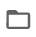

In [31]:
from tiatoolbox.utils.misc import download_data

# These file name are used for the experimenets
img_file_name = "sample_tile.png"
wsi_file_name = "sample_wsi.svs"


print('Download has started. Please wait...')

# Downloading sample image tile
download_data("https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/breast_tissue_crop.png", img_file_name)

# Downloading sample whole-slide image
download_data("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/wsi4_12k_12k.svs", wsi_file_name)

print('Download is complete.')

Download has started. Please wait...
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/breast_tissue_crop.png
Save to sample_tile.png
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/wsi4_12k_12k.svs
Save to sample_wsi.svs
Download is complete.


## Nuclei instance segmentation and classification using TIAToolbox's pretrained HoVer-Net model
In this section, we will investigate the use of the HoVer-Net model that has been already trained on the PanNuke dataset and incorporated in the TIAToolbox.
Particularly, the model we demonstrate can segment out nuclear instances in the image and assign one of the following 5 classes to them:
- Neoplastic Epithelial
- Non-Neoplastic Epithelial
- Inflammatory
- Connective
- Dead

### Inference on tiles
Much similar to the semantic segmentation functionality of the TIAToolbox, the instance segmentation module works both on image tiles and structured WSIs. First, we need to create an instance of the  `NucleusInstanceSegmentor` class which controls the  whole process of nuclei instance segmentation task and then use it to do prediction on the input image(s):

In [ ]:
# Tile prediction
inst_segmentor = NucleusInstanceSegmentor(
    pretrained_model="hovernet_fast-pannuke",
    num_loader_workers=2,
    num_postproc_workers=2,
    batch_size=4,
)

tile_output = inst_segmentor.predict(
        [img_file_name],
        save_dir="sample_tile_results/",
        mode="tile",
        on_gpu=ON_GPU,
        crash_on_exception=True,
    )

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/seg/hovernet_fast-pannuke.pth
Save to /root/.tiatoolbox/models/hovernet_fast-pannuke.pth


Process Batch: 100%|##############################| 3/3 [00:02<00:00,  1.03it/s]
|2021-11-29|16:08:44.656| [INFO] Finish: 0/1
|2021-11-29|16:08:44.659| [INFO] --Input: sample_tile.png
|2021-11-29|16:08:44.664| [INFO] --Ouput: /content/sample_tile_results/0


There we go! With only two lines of code, thousands of images can be processed automatically.
There are various parameters associated with `NucleusInstanceSegmentor`. We explain these as we meet them while proceeding through the notebook. Here we explain only the ones mentioned above:

- `pretrain_model`: specifies the name of the pretrained model included in the TIAToolbox (case sensitive). We are expanding our library of models pretrained on various (instance) segmentation tasks. You can find a complete list of available pretrained models [here](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=architecture#module-tiatoolbox.models.architecture). In this example, we use the `"hovernet_fast-pannuke"` pretrained model, which is HoVer-Net model trained on the [PanNuke dataset](https://arxiv.org/abs/2003.10778). Another option for HoVer-Net can be `hovernet_original-kumar` which is the original version of the HoVer-Net model trained on a dataset by [Kumar et al.](https://www.dropbox.com/s/j3154xgkkpkri9w/IEEE_TMI_NuceliSegmentation.pdf?dl=0)

- `num_loader_workers`: as the name suggests, this parameter controls the number of CPU cores (workers) that are responsible for the "loading of network input" process, which consists of patch extraction, preprocessing, etc.

- `num_postproc_workers`: as the name suggests, this parameter controls the number of CPU cores (workers) that are responsible for the "model related post-processing" tasks, which consist of horizontal and vertical maps gradient calculations, instance marker generation, and marker-controlled watershed method to generate the final instance map (for more information, please refer to [HoVer-Net paper](https://www.sciencedirect.com/science/article/pii/S1361841519301045)).

- `batch_size`: controls the batch size, or the number of input instances to the network in each iteration. If you use a GPU, be careful not to set the `batch_size` larger than the GPU memory limit would allow.

After the `inst_segmentor` has been instantiated as the instance segmentation engine with our desired pretrained model, one can call the `predict` method to do inference on a list of input images (or WSIs). The `predict` function automatically processes all the images on the input list and saves the results on the disk. The process usually comprises patch extraction (because the whole tile or WSI won't fit into limited GPU memory), preprocessing, model inference, post-processing and prediction assembly. There some important parameters that should be set to use the `predict` method properly:

- `imgs`: List of inputs to be processed. Note that items in the list should be paths to the inputs stored on the disk.

- `save_dir`: Path to the main folder in which prediction results for each input will be stored separately.
 
- `mode`: the mode of inference which can be set to either `'tile'` or `'wsi'` for plain histology images or structured whole slides images, respectively.

- `on_gpu`: can be either `True` or `False` to dictate running the computations on GPU or CPU.

- `crash_on_exception`: If set to `True`, the running loop will crash if there is an error during processing a WSI. Otherwise, the loop will move on to the next image (wsi) for processing. We suggest that you first make sure that the prediction is working as expected by testing it on a couple of inputs and then set this flag to `False` to process large cohorts of inputs.

In the `tile_output`, the `prediction` method returns a list of the paths to its inputs and the processed outputs saved on the disk. This can be used for loading the results for processing and visualisation.
Similar to prediction for `SemanticSegmentor` class, the `predict` method here can also accepts some arguments to set the input/output configurations of the model. These arguments are `ioconfig` (which accecpts a instance from `tiatoolbox.models.engine.semantic_segmentor.IOSegmentorConfig` class) or `resolution`, `patch_input_shape`, `patch_output_shape`, and `stride_shape` based on which an appropriate `IOSegmentorConfig` will be generated.
We should mention that when you are using TIAToolbox pretrained models, you don't need to worry about setting the input/output shape parameters as their optimal values will be loaded by default (it is recommended to use the default parameters).

Now that the prediction has finished, let's use the addresses in the `tile_output` variable to load the predictions look into them. For that, we need to use `joblib` package.


In [47]:
import joblib

tile_preds = joblib.load(f"{tile_output[0][1]}.dat")
print('Number of detected nuclei: {}'.format(len(tile_preds)))

# Extracting the nuclei IDs and select the first one
nuc_id_list = list(tile_preds.keys())
selected_nuc_id = nuc_id_list[0]
print('Nuclei prediction structure for nucleus ID: {}'.format(selected_nuc_id))
sample_nuc = tile_preds[selected_nuc_id]
print(sample_nuc.keys())
print('Bounding box: {}'.format(sample_nuc['box']))
print('Centroid: {}'.format(sample_nuc['centroid']))

Number of detected nuclei: 458
Nuclei prediction structure for nucleus ID: 0f6c9cb64e6a407192e1919f02a8b4ba
dict_keys(['box', 'centroid', 'contour', 'prob', 'type'])
Bounding box: [3695 4339 3723 4367]
Centroid: [3708.54222973 4352.53547297]


After loading the prediction for the first image in the `tile_output` list (there is only one image or path in this example), we can see that the nuclei predictions for that image are stored in a Python Dictionary each with a unique dictionary key which we will call `nuc_id` from now on. Here is the dictionary format:
```
sample_dict = {instance_id: {
                             box: List[],
                             centroid: List[],
                             contour: List[List[]],
                             prob: float,
                             type: int
                             }
                ... # other instances
              }
```

One can extract the list of all nuclei IDs by calling `nuc_id_list = list(tile_preds.keys())`. The value for each `nuc_id` is a dictionary itself which contains information related to that particular nucleus instance. Each nucleus instance dictionary consists the following information (keys):
- `'box'`: Bounding box information in the $[x_{top-left}, y_{top-left}, width, hight]$ format.
- `'centroid'`: Centroid of of the nucleus in the $[x_{centre}, y_{centre}]$ format.
- `'contour'`: A list of points that form the contour or segmentation boundaries (polygon) of the nucleus. This can be used to regenerate the nucleus mask.
- `'prob'`: The probability of type prediction.
- `'type'`: Predicted type or label for the nucleus which can be a natural number between 0-5: {0: 'neoplastic epithelial', 1: 'Inflammatory', 2: 'Connective', 3: 'Dead', 4: 'non-neoplastic epithelial'} 

### Instance Segmentation Visualisation
Investigating the quality of instance segmentation/classification by going through the predicted nuclei dictionary, as explained above, is impossible. A good workaround is to visualize the instance segmentation results on the input image to check the quality of instance segmentation and classification. To this end, TIAToolbox has incorporated a boundary visualization tool, called `overlay_prediction_contours`.

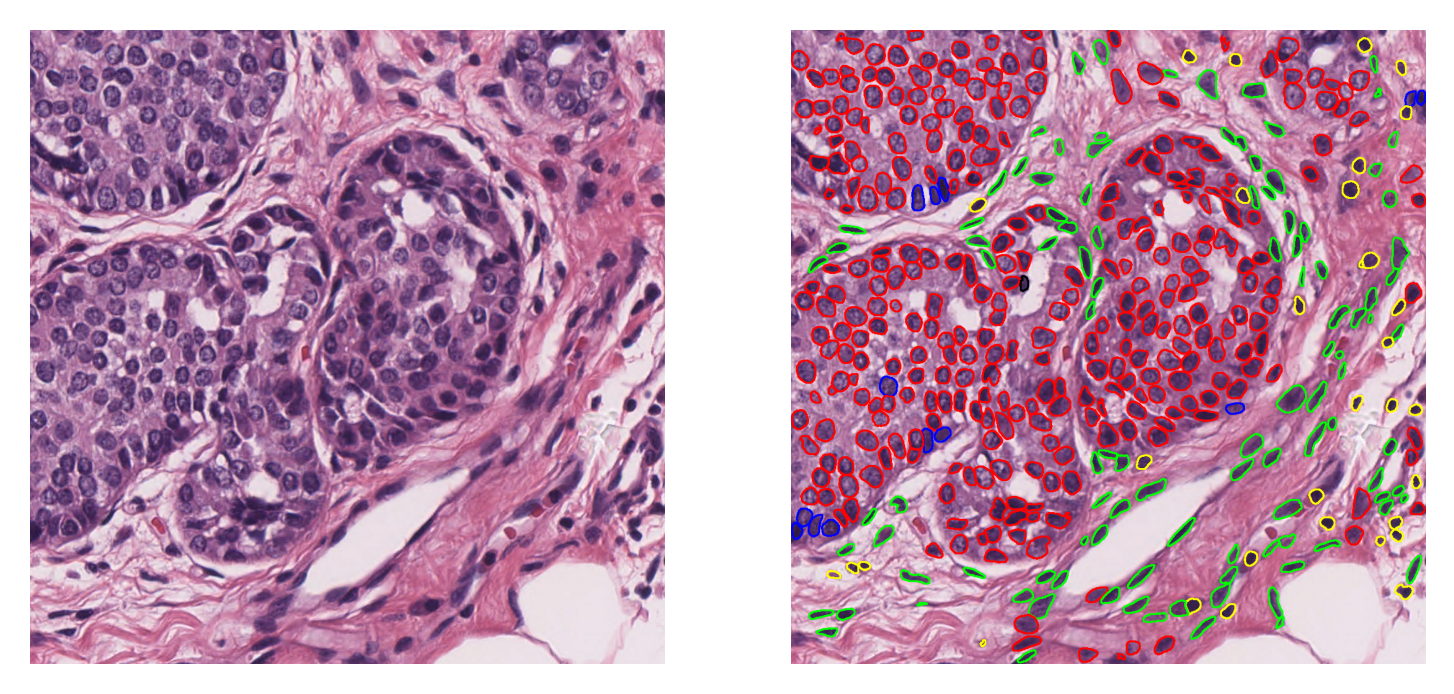

In [ ]:
from tiatoolbox.utils.visualization import  overlay_prediction_contours

# Reading the original image
tile_img = imread(img_file_name)

# defining the coloring dictionary: a dictionary that specifies a color to each class {type_id : (type_name, colour)}
color_dict = {0: ('neoplastic epithelial', (255, 0, 0)),
              1: ('Inflammatory', (255, 255, 0)),
              2: ('Connective', (0, 255, 0)),
              3: ('Dead', (0, 0, 0)),
              4: ('non-neoplastic epithelial', (0, 0, 255))}

# Create the overlay image
overlaid_predictions = overlay_prediction_contours(canvas=tile_img,
                                                   inst_dict=tile_preds ,
                                                   draw_dot=False,
                                                   type_colours =color_dict,
                                                   line_thickness=2)

# showing processed results alongside the original images
fig = plt.figure()
ax1 = plt.subplot(1,2,1), plt.imshow(tile_img), plt.axis('off')
ax2 = plt.subplot(1,2,2), plt.imshow(overlaid_predictions), plt.axis('off')

As you can see, `overlay_prediction_contours` beautifully generates an image that has the instance segmentation classification overlaid. Here are the explanations regarding this function's arguments:

- `canvas`: the image on which we would like to overlay the predictions. This is should be the same image used as the input to the `predict` method, loaded as a numpy array.
- `inst_dict`: predicted instance dictionary. This is the dictionary that we earlier loaded using `joblib.load()` function which is the output of HoVer-Net and contains the information of predicted instances.
- `draw_dot`: specifies whether to draw detected nuclei centroid on the overlap map as well. Default is False.
- `type_colours`: a dictionary containing the name and colour information for each class in the prediction. We know that the used HoVer-Net model in this example predicts 5 classes of cells, therefore we created the `color_dict` which contains colour information for all types. The `type_colours` dictionary should be of the `{type_id : (type_name, colour)}` format where `type_id` is from 0-N (corresponding to classes) and `colour` is a tuple (R, G, B) specifying the colour in RGB format.
`inst_colours`: if you only have the instance segmentation results or do not like to colour instances based on their types, you can set this parameter to assign a colour for all instances or provide a list of colours to assign different colours to different instances in `inst_dict`.


### Inference on WSIs
The next step is to use the TIAToolbox's embedded model for nuclei instance segmentation on a whole slide image. The process is quite similar to what we have done for tiles. We will just introduce  some important parameters that should be considered when configuring the instance segmentor for WSI inference.

Here we re-defined the `inst_segmentor` just to show the use of `auto_generate_mask` parameter. By setting this parameter to `True`, we are telling the TIAToolbox to automatically extract the tissue masks of the input WSIs if they are not provided in the `predict` function parameters.
In this example, we leave `auto_generate_mask=False` because we are using a WSI that only contains tissue region (there is no background region) and therefore there is no need for tissue mask extraction.
> Please note that this part may take too long to process, depending on the system you are using (GPU enabled/disabled) and how large the input WSI is.

In [ ]:
# Instantiate the nuclei instance segmentor
inst_segmentor = NucleusInstanceSegmentor(
    pretrained_model="hovernet_fast-pannuke",
    num_loader_workers=4,
    num_postproc_workers=4,
    batch_size=8,
    auto_generate_mask=False,
    verbose=False,
)

# WSI prediction (if ON_GPU=False, this part will take more than a couple of hours to process)
wsi_output = inst_segmentor.predict(
        [wsi_file_name],
        masks=None,
        save_dir="sample_wsi_results/",
        mode="wsi",
        on_gpu=ON_GPU,
        crash_on_exception=True,
    )

Note the only differences made here are:
1. Adding `auto_generate_mask=False` to the `NucleusInstanceSegmentor`. If `True`, the toolbox automatically extracts tissue masks from WSIs if there is no `masks` input is provided to the `predict` function.
2. Setting `mode='wsi'` in the `predict` method arguments indicates that we are predicting region segmentations for inputs in the form of WSIs.
3. `masks=None` in the `predict` function: `masks` argument similar to the `imgs` should be a list of paths to the desired image masks. Patches from `imgs` are only processed if they are within a masked area of their corresponding `masks`. If not provided (`masks=None`), then a tissue mask will be automatically generated for whole-slide images or the entire image is processed for image tiles.

The above cell might take a while to process, especially if you have set `ON_GPU=False`. The processing time mostly depends on the size of the input WSI.
The outout of `predict` function, `wsi_output`, contains a list of paths to the input WSIs and their corresponding results saved on the the disk. The results for nuclei instance segmentation in `'wsi'` mode are stored just similar to the `'tile'` mode, in Python dictionary.
Let's use the `joblib` and load the outputs for this sample WSI and look into the results dictionary.

In [48]:
import random
import joblib

wsi_pred = joblib.load(f"{wsi_output[0][1]}.dat")
print('Number of detected nuclei: {}'.format(len(wsi_pred)))

# Extracting the nuclei IDs and select a random nucleus
nuc_id_list = list(wsi_pred.keys())
selected_nuc_id = nuc_id_list[random.randint(0, len(wsi_pred))] # randomly selecting a nuclei
print('Nuclei prediction structure for nucleus ID: {}'.format(selected_nuc_id))
sample_nuc = wsi_pred[selected_nuc_id]
print(sample_nuc.keys())
print('Bounding box: {}'.format(sample_nuc['box']))
print('Centroid: {}'.format(sample_nuc['centroid']))

Number of detected nuclei: 23180
Nuclei prediction structure for nucleus ID: 51c07ac8dd1c4d4c850e51e9320d4e6f
dict_keys(['box', 'centroid', 'contour', 'prob', 'type'])
Bounding box: [8098  985 8141 1019]
Centroid: [8118.45523091 1000.89066918]


More than 23000 nuclear instances are segmented and classified within a WSI using only two simple lines of code and this process can be generalized to thousands of WSIs by only providing the list of WSI paths as input to the `predict` function.

Now, we usually cannot visualize all of the nuclear instances the same way we did for an image tile, because the real pixel size of most of the WSIs is quite large and they cannot be directly loaded into the system memory. On the other hand, the number of nuclei is so large and most of the screens are so small that even if we create the overlay image, we will not be able to distinguish the individual nuclei from each other. Below, we load the input WSI to the `predict` function, create its overview and display it to better illustrate this limitation.

|2021-11-30|15:55:59.403| [WARNING] d:\PythonProjects\tiatoolbox\tiatoolbox\wsicore\wsireader.py:306: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."



WSI original dimensions: (12000, 12000)
WSI overview dimensions: (12024, 12024, 3)


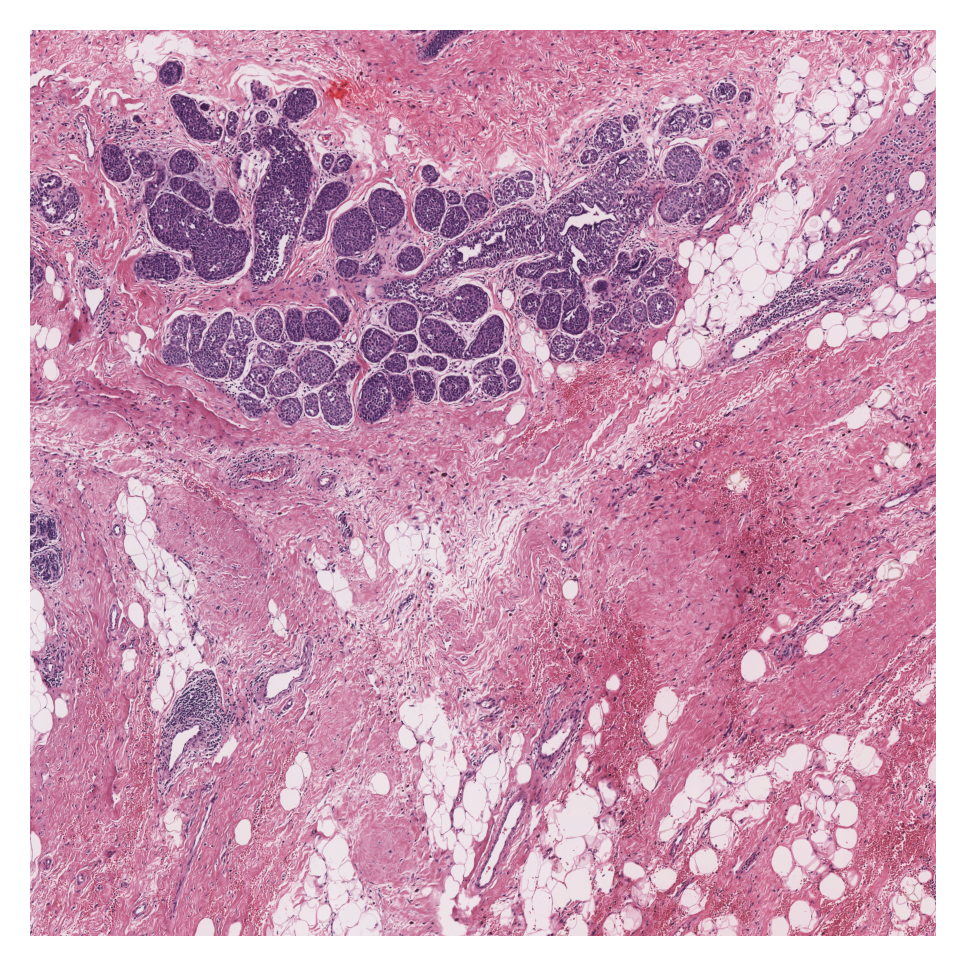

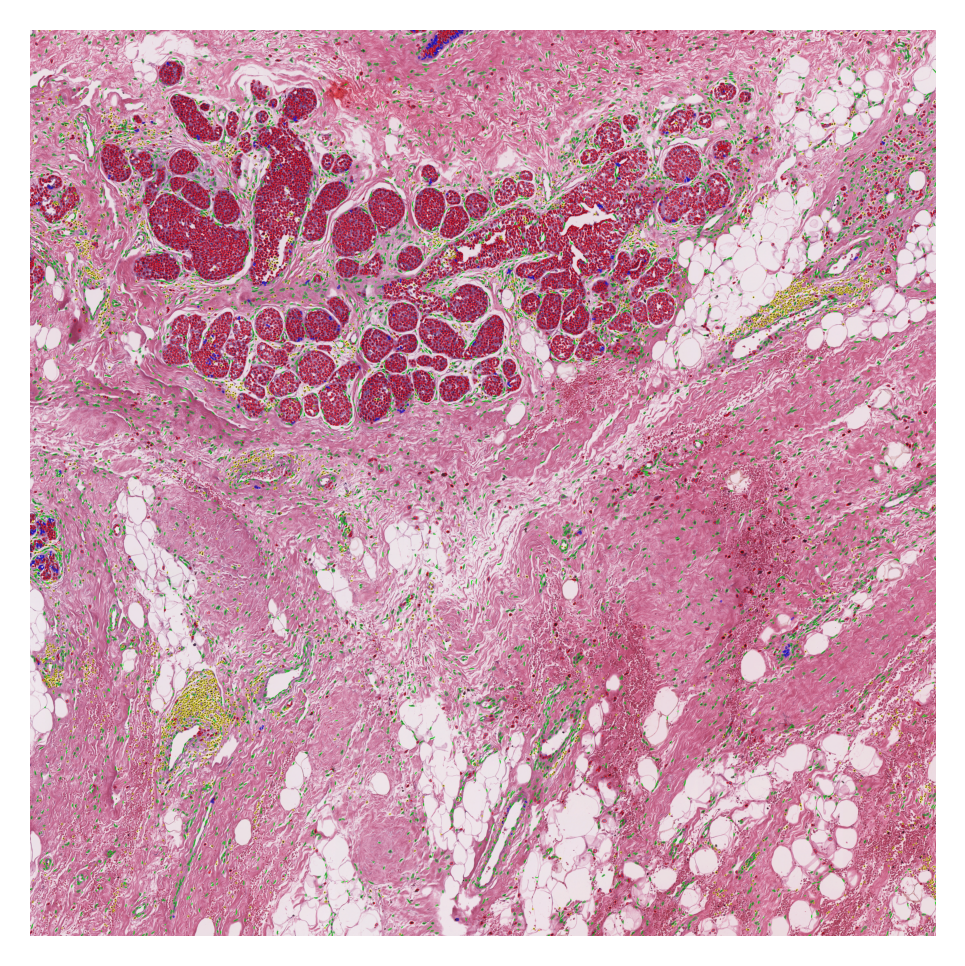

In [49]:
from tiatoolbox.utils.visualization import  overlay_prediction_contours

# [WSI overview extraction]
# Reading the WSI
wsi = get_wsireader(wsi_file_name)
print('WSI original dimensions: {}'.format(wsi.info.slide_dimensions))

# Reading the whole slide in the highest resolution as a plane image
wsi_overview = wsi.slide_thumbnail(resolution=0.25, units='mpp')
print('WSI overview dimensions: {}'.format(wsi_overview.shape))

color_dict = {0: ('neoplastic epithelial', (255, 0, 0)),
              1: ('Inflammatory', (255, 255, 0)),
              2: ('Connective', (0, 255, 0)),
              3: ('Dead', (0, 0, 0)),
              4: ('non-neoplastic epithelial', (0, 0, 255))}

# Create the overlay image
overlaid_predictions = overlay_prediction_contours(canvas=wsi_overview,
                                                   inst_dict=wsi_pred ,
                                                   draw_dot=False,
                                                   type_colours =color_dict,
                                                   line_thickness=4)

# showing processed results alongside the original images
fig=plt.figure(), plt.imshow(wsi_overview), plt.axis('off')
fig=plt.figure(), plt.imshow(overlaid_predictions), plt.axis('off')



Although here we managed to overlay the results on the WSI (because this WSI is of size 12000x12000 which is relatively smaller than typical WSIs with pixels sizes larger than 100000x100000), we cannot distinguish a single nucleus in this big picture. However, to show the performance of the nuclei instance segmentation/classification, we will select four random nuclear instances and visualize them with their segmentation map overlaid on them. We will do this by leveraging the detected nuclei `centroid` information and `read_rect` functionality of the TIAToolbox WSI object.

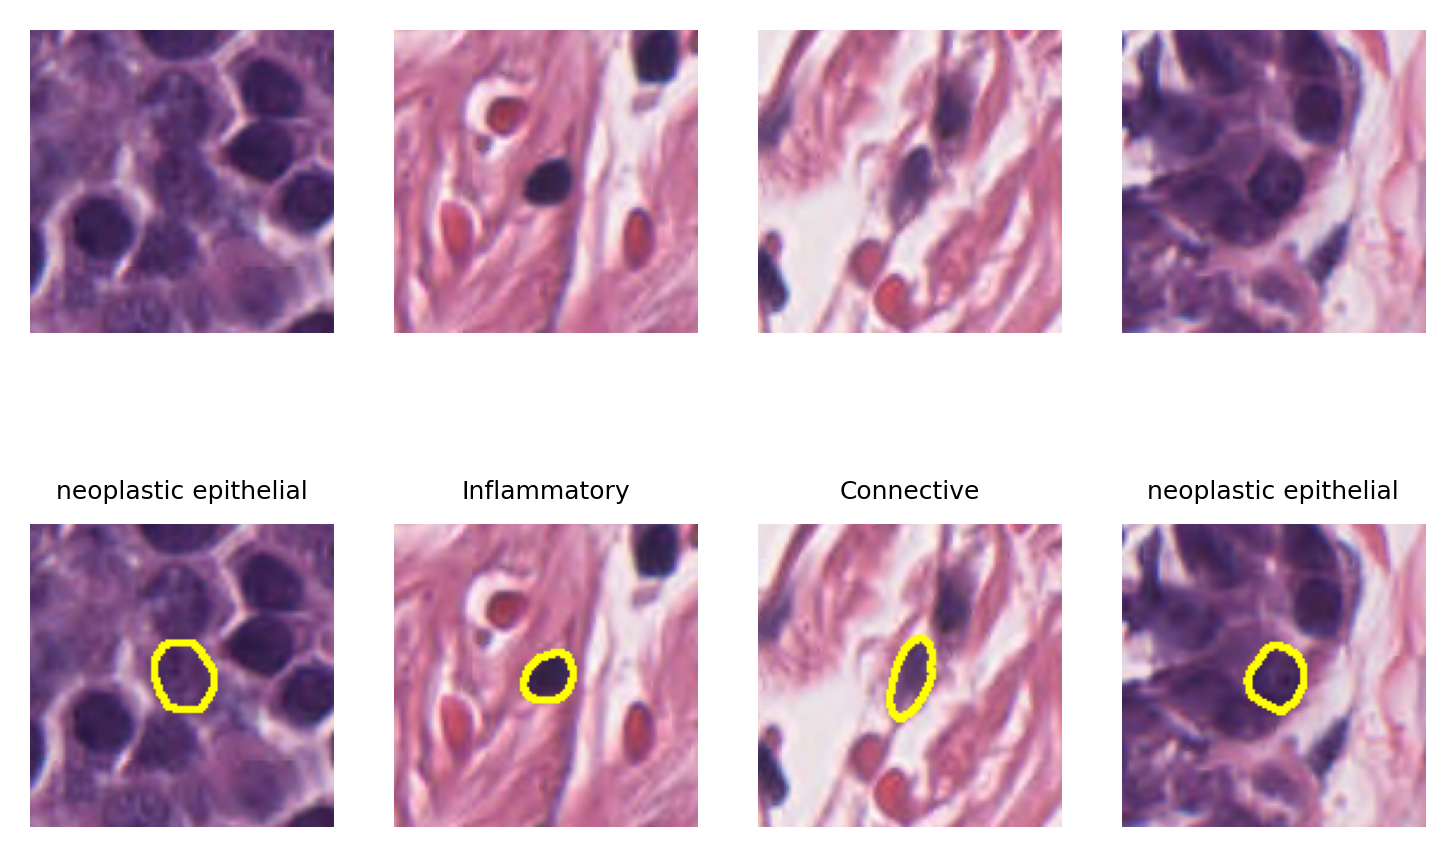

In [28]:
import cv2
bb = 128 # box size for patch extraction around each nucleus

# defining the coloring dictionary: a dictionary that specifies a color to each class {type_id : (type_name, colour)}
color_dict = {0: ('neoplastic epithelial', (255, 0, 0)),
              1: ('Inflammatory', (255, 255, 0)),
              2: ('Connective', (0, 255, 0)),
              3: ('Dead', (0, 0, 0)),
              4: ('non-neoplastic epithelial', (0, 0, 255))}

for i in range(4): # showing 4 examples
    selected_nuc_id = nuc_id_list[random.randint(0, len(wsi_pred))] # randomly selecting a nuclei
    sample_nuc = wsi_pred[selected_nuc_id]
    cent = np.int32(sample_nuc['centroid']) # centroid position in WSI coordinate system
    contour = sample_nuc['contour'] # nuceli contour points in WSI coordinate system
    contour -= cent-bb//2 # nuceli contour points in the small patch coordinate system

    # Now reading the nuclei small window neighborhood
    nuc_patch = wsi.read_rect(cent-bb//2, bb, resolution=0.25, units='mpp', coord_space='resolution')
    # Overlay contour points on the extracted patch using open-cv drawContours functionality
    overlaid_patch = cv2.drawContours(nuc_patch.copy(), [contour], -1, (255, 255, 0), 2)

    # plotting the results
    ax = plt.subplot(2, 4, i+1), plt.imshow(nuc_patch),  plt.axis('off')
    ax = plt.subplot(2, 4, i+5), plt.imshow(overlaid_patch), plt.axis('off'), plt.title(color_dict[sample_nuc['type']][0])

In summary, it is very easy to use the pretrained HoVer-Net model in the TIAToolbox to do nuclear instance segmentation and classification. You don't even need to set any parameters related to a model’s input/output when you decide to work with one of TIAToolbox’s pretrained models (they will be set automatically, based on their optimal values). Here we explain how the parameters work, so we need to show them explicitly. In other words, nuclei instance segmentation in images/WSIs can be done as easily as:
```
segmentor = NucleusInstanceSegmentor(pretrained_model="hovernet_fast-pannuke", num_loader_workers=4, batch_size=4)
output = segmentor.predict([img_file_name], save_dir="sample_results/", mode="tile")
```

Feel free to play around with the parameters, models, and experiment with new images (just remember to run the first cell of this notebook again, so the created folders for the current examples would be removed or change the `save_dir` parameters in new calls of `predict` function). Furthermore, if you want to use your pretrained model for instance segmentation (or any other pixel-wise prediction models) in the TIAToolbox framework, you can follow the instructions in our example notebook on [advanced model techniques](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/examples/07_example_modeltechniques.ipynb) to gain some insights and guidance.
We welcome any trained model in computational pathology (in any task) for addition to TIAToolbox. If you have such a model (in Pytorch) and want to contribute, please contact us or simply create a PR on our Github page.